<a href="https://colab.research.google.com/github/ichakraborty/simulation/blob/main/mask_policy_aug_tracker_h1n1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math 
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix as csr
from sklearn.decomposition import NMF
import itertools
import re
import random
import pandas as pd

#Importing Data

We get the datasets that will be used and load them as csvs

In [ ]:
!wget https://raw.githubusercontent.com/OxCGRT/USA-covid-policy/master/data/OxCGRT_US_latest.csv
!wget https://raw.githubusercontent.com/ichakraborty/simulation/main/h1n1.csv
!wget https://raw.githubusercontent.com/skangasl/cs156/main/WHO_NREVSS_Clinical_Labs.csv
!wget https://raw.githubusercontent.com/skangasl/cs156/main/WHO_NREVSS_Public_Health_Labs.csv
!wget https://raw.githubusercontent.com/skangasl/cs156/main/weeks.csv

--2021-05-28 11:14:46--  https://raw.githubusercontent.com/OxCGRT/USA-covid-policy/master/data/OxCGRT_US_latest.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16505935 (16M) [text/plain]
Saving to: ‘OxCGRT_US_latest.csv.6’

OxCGRT_US_latest.cs 100%[===================>]  15.74M  39.2MB/s    in 0.4s    

2021-05-28 11:14:47 (39.2 MB/s) - ‘OxCGRT_US_latest.csv.6’ saved [16505935/16505935]

--2021-05-28 11:14:47--  https://raw.githubusercontent.com/ichakraborty/simulation/main/h1n1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Len

In [ ]:
us_pol = pd.read_csv('OxCGRT_US_latest.csv')
h1n1 = pd.read_csv('h1n1.csv')
clinical = pd.read_csv('WHO_NREVSS_Clinical_Labs.csv')
public_health = pd.read_csv('WHO_NREVSS_Public_Health_Labs.csv')

# Displaying Data

We display some of our data and do some initial preprocessing to get the total number of flu cases of all types.

In [ ]:
clinical.head()

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B
0,National,X,2019,40,19851,136,124,1.30976,0.685104,0.624654
1,National,X,2019,41,22113,146,181,1.47877,0.660245,0.818523
2,National,X,2019,42,23131,172,187,1.55203,0.743591,0.808439
3,National,X,2019,43,24630,201,354,2.25335,0.816078,1.437270
4,National,X,2019,44,25417,221,556,3.05701,0.869497,2.187510


In [ ]:
public_health.head()

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,A (2009 H1N1),A (H3),A (Subtyping not Performed),B,BVic,BYam,H3N2v
0,National,X,2019,40,987,25,57,21,7,56,1,0
1,National,X,2019,41,1101,33,64,22,7,70,2,0
2,National,X,2019,42,1256,36,82,24,13,77,3,0
3,National,X,2019,43,1494,53,78,48,20,96,5,0
4,National,X,2019,44,1597,52,61,83,39,120,5,0


In [ ]:
us_tot = pd.DataFrame()
us_tot['week'] = clinical['WEEK']
us_tot['flu_cases'] = clinical['TOTAL A'] + clinical['TOTAL B'] + public_health['A (2009 H1N1)'] + public_health['A (H3)'] + public_health['B'] + public_health['BVic'] + public_health['BYam'] + public_health['H3N2v']
us_tot['year'] = clinical['YEAR']
us_tot.head()

,week,flu_cases,year
0,40,406,2019
1,41,503,2019
2,42,570,2019
3,43,807,2019
4,44,1054,2019


In [ ]:
h1n1.head()

,week,h1n1 positive tests,total positive tests,year
0,17,326,1892,2009
1,18,441,1454,2009
2,19,742,1074,2009
3,20,1096,1450,2009
4,21,1558,2074,2009


# Preprocessing
We construct the training data by preprocessing dates and getting the average US masking policy during a given week.

In [ ]:
weeks = pd.read_csv('weeks.csv')
weeks_np = weeks.to_numpy()
masks = us_pol[['RegionName','H6_Facial Coverings', 'Date']]

In [ ]:
masks_clean = masks.dropna()
def get_week(date):
  if date >= 20210101:
    return 0
  elif date >= 20201005:
    date -= 10000
  for i in range(0, len(weeks_np)):
    if weeks_np[i][1] >= date:
      return weeks_np[i][0]

masks_clean['week'] = masks_clean['Date'].apply(get_week)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
mask_pol = masks_clean[['week', 'H6_Facial Coverings']].groupby(['week'])['H6_Facial Coverings'].agg('mean')
mask_pol[1.0] = 0.0

In [ ]:
in_df = us_tot
mask_np = mask_pol.to_numpy()
h1n1_np = h1n1.to_numpy()
def get_mask(week_val):
  return mask_np[week_val]
def get_h1n1(week_val):
  for i in range(len(h1n1_np)):
    if h1n1_np[i][0] == week_val:
      return h1n1_np[i][1]
in_df['masking'] = in_df['week'].apply(get_mask)
in_df['h1n1_cases'] = in_df['week'].apply(get_h1n1)
df = in_df[['week', 'flu_cases', 'masking']]
df.head()

,week,flu_cases,masking
0,40,406,2.823529
1,41,503,2.829132
2,42,570,2.868347
3,43,807,2.915966
4,44,1054,2.921569


# Models

We run xgboost, decision tree, and random forest classifiers on a 90-10 train test split


In [ ]:
from sklearn import *
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

X = (df[['week', 'masking']].to_numpy()).tolist()  
week_idxs = (df['week'].to_numpy()).tolist()
X.extend([[week, 0.0] for week in week_idxs])
X = np.asarray(X)

Y = (df['flu_cases'].to_numpy()).tolist()
Y.extend((in_df['h1n1_cases'].to_numpy()).tolist())
Y = np.asarray(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

xgb = XGBClassifier( max_depth=6, eta = 0.1)
xgb.fit(X_train, Y_train)

pred = xgb.predict(X_test)
err = r2_score(Y_test,pred, multioutput='uniform_average')
print(err)


-0.2445980672375565


In [ ]:
from sklearn import tree


dt = tree.DecisionTreeClassifier(criterion='gini', max_depth= 7)
dt.fit(X_train, Y_train)

pred_dt= dt.predict(X_test)
err_dt = r2_score(Y_test,pred_dt, multioutput = 'uniform_average')
print(err_dt)

-0.7477721725485782


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion = 'gini', max_depth = 6, min_samples_leaf = 3 )

rf.fit(X_train, Y_train)

pred_rf= rf.predict(X_test)
err_rf = r2_score(Y_test,pred_rf, multioutput = 'uniform_average')
print(err_rf)

-0.6567899526838743


# Predictions
We predict a flu season with various policies using the trained models and show a baseline of h1n1 cases in the 2009-2010 flu season.

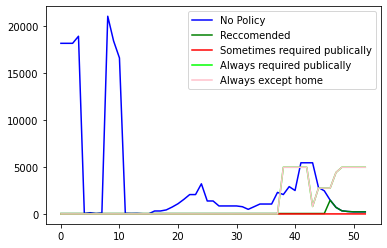

In [ ]:
import matplotlib.pyplot as plt
predictions =[]

for level in range (0, 5):
  x_exp = []
  for i in range(0, 53):
    x_exp.append([i, level])
  predictions.append(np.asarray([rf.predict(x_exp)]))

predictions

weeks = list(range(0, 53, 1))
plt.plot(weeks, predictions[0].T, color = "blue", label = "No Policy")
plt.plot(weeks, predictions[1].T, color = "green", label = "Reccomended")
plt.plot(weeks, predictions[2].T, color = "red",label = "Sometimes required publically" )
plt.plot(weeks, predictions[3].T, color = "lime", label = "Always required publically")
plt.plot(weeks, predictions[4].T, color = "pink", label = "Always except home")


plt.legend(loc="upper right")

plt.show()

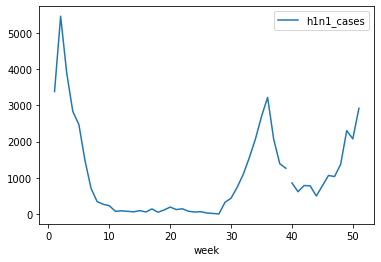

In [ ]:
plot_df = pd.DataFrame(in_df['h1n1_cases'], index=in_df['week'])
plot_df.plot()